# Trabajo Práctico II - Simulación 

Integrantes: 
- Matías José Cano - 97925
- Gustavo Giménez - 94038
- Gonzalo Petraglia - 97811

# Ejercicio 1

Base de datos distribuida:
<img src="db_distribuida.png" alt="Drawing" style="width: 600px;"/>

Base de datos central:

<img src="db_central.png" alt="Drawing" style="width: 600px;"/>

In [90]:

from scipy.stats import expon
import random

def accumulate(probs):
    acc = []
    accumulated = 0
    for p in probs:
        accumulated += p
        acc.append(accumulated)
    return acc


def simulate_distributed_db(mean_time_of_incoming_request, 
                            mean_time_by_db, 
                            db_probabilities, 
                            size):
    
    assert(sum(db_probabilities) == 1)
    assert(len(mean_time_by_db) ==  len(db_probabilities))

    
    ## Obtengo funcion de distribución acumulada a traves de pmf
    db_acum_probabilities = list(accumulate(db_probabilities)) 

    
    ## El tiempo de liberación se incrementa en tiempo de procesado
    ## a partir de cuando puedo empezar a procesar la nueva solicitud    
    def free_at(old_free_at, current_time, time_taken):
        return max(old_free_at, current_time) + time_taken 
    
    gonna_be_free_at = [0, 0]
    total_waiting_times_sum = 0
    waiting_queue_times_sum = 0
    requests_that_waited_extra = 0
    
    incoming_requests_delta = expon.rvs(scale=mean_time_of_incoming_request, size=size)
    times_to_process_request_not_scaled = expon.rvs(size=size)
    
    time = 0
    for income_delta, process_time_not_scaled in \
                zip(incoming_requests_delta, times_to_process_request_not_scaled):
        
        time += income_delta
        
        r = random.uniform(0.0,1.0)
        dbs_turn = next(i for i, p in enumerate(db_acum_probabilities) if r < p)
        process_time = process_time_not_scaled * mean_time_by_db[dbs_turn]
        
        new_free_time_of_db = free_at(gonna_be_free_at[dbs_turn], time, process_time)
                
        total_waiting_time = new_free_time_of_db - time
        gonna_be_free_at[dbs_turn] = new_free_time_of_db
        total_waiting_times_sum += total_waiting_time
        waiting_in_queue_time = total_waiting_time - process_time
        waiting_queue_times_sum += waiting_in_queue_time
        
        # Delta de seguridad de redondeo
        has_to_wait_extra = (waiting_in_queue_time > 0.00001)
        if has_to_wait_extra:
            requests_that_waited_extra += 1
            
    return waiting_queue_times_sum / size, total_waiting_times_sum/size, \
            float(requests_that_waited_extra)/size
        
    

print(
"""
1) Caso con db distribuida
Tiempo medio de espera en cola: {0} 
Tiempo medio de espera en cola + procesamiento: {1} 
Solicitudes que no esperaron: {2}
""".format(*simulate_distributed_db(4, [0.7, 1], [0.6, 0.4], 100000))
)

print(
"""
2) Caso con db central
Tiempo medio de espera en cola: {0} 
Tiempo medio de espera en cola + procesamiento: {1} 
Solicitudes que no esperaron: {2}
""".format(*simulate_distributed_db(4, [0.8], [1], 100000))
)


1) Caso con db distribuida
Tiempo medio de espera en cola: 0.090854155435 
Tiempo medio de espera en cola + procesamiento: 0.906999255276 
Solicitudes que no esperaron: 0.10208


2) Caso con db central
Tiempo medio de espera en cola: 0.196747803568 
Tiempo medio de espera en cola + procesamiento: 0.995979243226 
Solicitudes que no esperaron: 0.19826



De los resultados obtenidos se pueden sacar las siguientes conclusiones:

La base de datos distribuida es una opción mas performante en todos los paremetros medidos. En algunos es hasta 2 veces mejor. Sin embargo, ya que el tiempo medio total que pasa una solicitud en el sistema no es menor que la mitad para el caso distribuido con respecto al caso centralizado, según el criterio dado se sugiere por utilizar la base de datos centralizada.

# Ejercicio 2


Suponiendo que esto es modelable por una cadena de Markov (es decir que el proceso es discretizable y que la probabilidad de llegar a un estado es solo dependiente del estado anterior), que las probabilidades dadas son independientes, que el servidor puede tener infinitas solicitudes pendientes, que una solicitud no puede ser resuelta en el mismo intervalo en el que llega y que no puede suceder que dos solicitudes lleguen o se resuelvane en un paso, la matriz de transición sera:


    |    r    |    p    |    0    |  0  |...|       
    | P = r*q | r*s+p*q |   p*s   |  0  |...|
    |    0    |   r*q   | r*s+p*q | p*s |...|
    |    .    |    .    |    .    |  .  | . |
    |    .    |    .    |    .    |  .  | . |
    |    .    |    .    |    .    |  .  | . |

 siendo p = 1/30, q = 1/40, r = 1 - p y s = 1 - q
 
Esta matriz se obtiene definiendo a cada posible estado como la cantidad de solicitudes en proceso. Dado esto, la matriz puede ser pensada en 2 etapas.

Por un lado, si tenemos mas de una solicitud pendiente, la probabilidad de que tengamos una solicitud menos pendiente en el siguiente estado es igual a la probabilidad de que una solicitud se procese y no llegue otra; como pedimos que estos eventos sean independientes la probabilidad de esto sera igual al producto de la probabilidad de estos eventos, es decir r*q. Por otro lado, para que en el siguiente estado haya una solicitud pendiente más lo que debe suceder es que llegue una solicitud pero que ninguna haya sido procesada, por lo que la probabilidad sera p*s. Finalmente, para mantenernos en el mismo estado debe suceder que se procese una solicitud y llegue otra o que ninguna de estas dos cosas suceda, por lo que la probabilidad sera r*s+p*q. Como se puede observar, y es esperable, la suma de las probabilidades de todas las transiciones es 1.

Por otro lado, si no hay solicitudes pendientes, la probabilidad de tener una solicitud en el siguiente estado es igual a la probabilidad de que llegue una solicitud, ya que son eventos equivalentes; y la probabilidad de seguir teniendo 0 solicitudes es la probabilidad es igual a uno menos la anterior probabilidad.

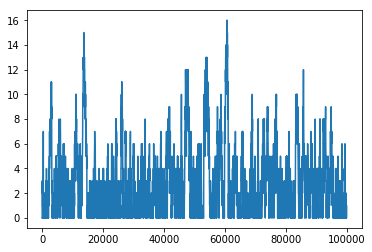

In [88]:
import matplotlib.pyplot as plt

def request_processed():
    return random.random() < 1.0/30
    
def incoming_request():
    return random.random() < 1.0/40

steps = int(1000 / 0.01)

pending_requests = 0
states = []
for i in range(steps):
    states.append(pending_requests)
    if pending_requests > 0 and request_processed():
        pending_requests -= 1
    
    if pending_requests < 29 and incoming_request():
        pending_requests += 1

plt.plot(states)
plt.show()

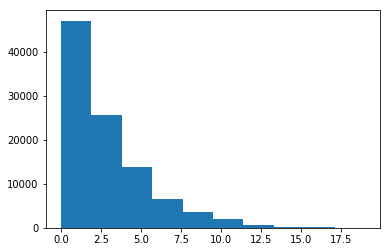

In [77]:
plt.hist(states)
plt.show()

In [96]:
times_without_request = len(list(filter(lambda x: x == 0, states)))

print ('El porcentaje de tiempo que el servidor se encuentra sin procesar ' +
       'solicitudes es de {}%'.format(float(times_without_request)/len(states)*100))

El porcentaje de tiempo que el servidor se encuentra sin procesar solicitudes es de 24.954%


# Ejercicio 3

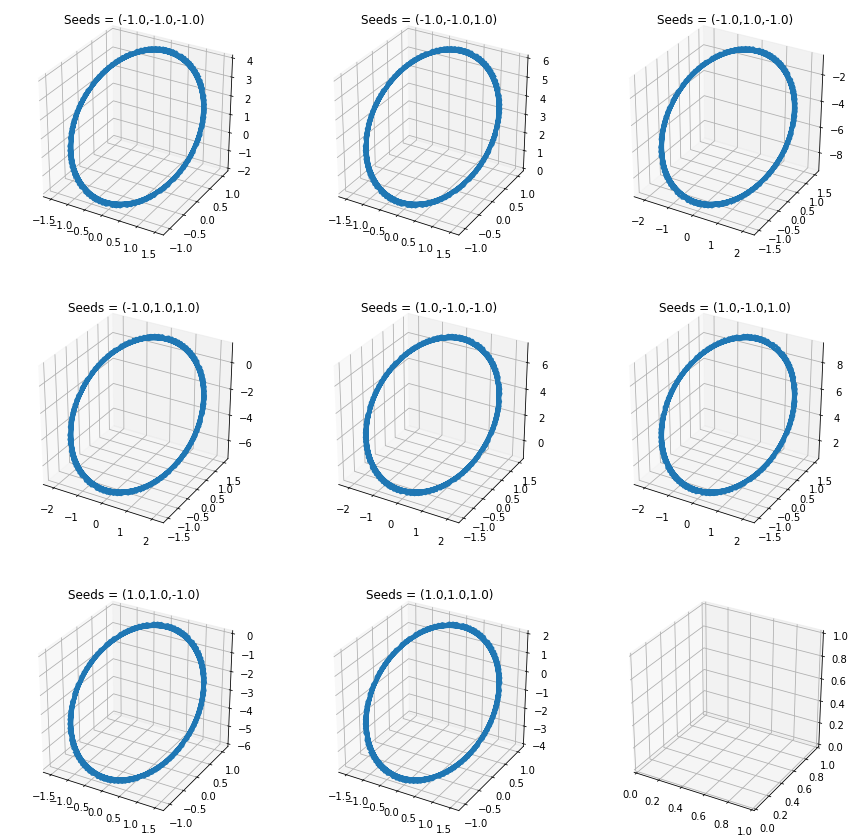

In [91]:
from mpl_toolkits.mplot3d import Axes3D

def calculate_new_state(x,y,z):
    return x/2 + y, y - x/2, z - x - y

x_seeds = [-1.0, 1.0]
y_seeds = [-1.0, 1.0]
z_seeds = [-1.0, 1.0]

fig, axs = plt.subplots(3, 3, figsize=(15, 15), subplot_kw={'projection': '3d'})
fig.subplots_adjust(hspace = .2, wspace=.2)
axs = axs.ravel()

i = 0
for x_seed in x_seeds:
    for y_seed in y_seeds:
        for z_seed in z_seeds:       
            x =  x_seed
            xs = [x]
            y = y_seed
            ys = [y]
            z = z_seed
            zs = [z]
            for j in range(100):
                x, y, z = calculate_new_state(x,y,z)
                xs.append(x)
                ys.append(y)
                zs.append(z)
            axs[i].plot(xs,ys,zs)
            axs[i].set_title(
                "Seeds = ({0},{1},{2})".format(x_seed, y_seed, z_seed))
            i += 1

plt.show()


Se nota que todos presentan el mismo comportamiento salvo por un escalamiento y/o desplazamiento, presentan un ciclo limite. Esto es esperable ya que las matrices para todos los sistemas son identicos (salvo por los seeds), y lineales; y como los sistemas lineales presentan el mismo comportamiento a lo largo de todo el espacio de fases, el comportamiento deberia ser similar para todo conjunto inicial de seeds.

Ademas, el ciclo limite es esperable tambien dado que los autovalores dominantes de la matriz que define al sistema* son de modulo igual a 1 y son complejos. Los autovalores son

$$ 0 , \frac{1}{2}i\left(\sqrt{3}+i\right),\:-\frac{1}{2}i\left(\sqrt{3}-i\right) $$

# Puntos fijos

Tienen que cumplir las ecuaciones

$$ 2 \cdot x_{t} = x_{t-1} + 2 \cdot y_{t-1} $$

$$ y_{t}  = y_{t-1} - \frac{x_{t-1}}{2} $$

$$ z_{t} = z_{t-1} - x_{t-1} - y_{t-1} $$


Al despejar:

$$ 0 = -x + 2 \cdot y $$

$$ 0 = -x/2 $$

$$ 0 = - x - y $$

Por lo tanto:

- $x = 0$
- $y = 0$
- $z$ puede tomar cualquier valor

Por lo tanto, los puntos fijos del sistema se encuentran en el eje z.

Esto se debe a que si bien, el sistema es lineal y según la teoría estos sistemas deberian de tener un solo punto fijo, la matriz que define al sistema* es no inversible, por lo que realmente tenemos un subespacio de dimensión 1 (cantidad de ecuaciones no L.I) de puntos fijos.

Nota esta no invertibilidad se ve facilmente teniendo en cuenta que si z(t) = z(t-1) (propiedad de punto fijo), z se puede cancelar en todas las ecuaciones.


Esto se ve en los  siguientes gráficos donde los seeds se dan sobre el eje y sucede que no se ve nada, ya que realmente las sucesivas iteraciones caen en el mismo punto

Nota*: La matriz que define al sistema es la siguiente: \begin{pmatrix}-1&2&0\\ \:-\frac{1}{2}&0&0\\ \:-1&-1&0\end{pmatrix}

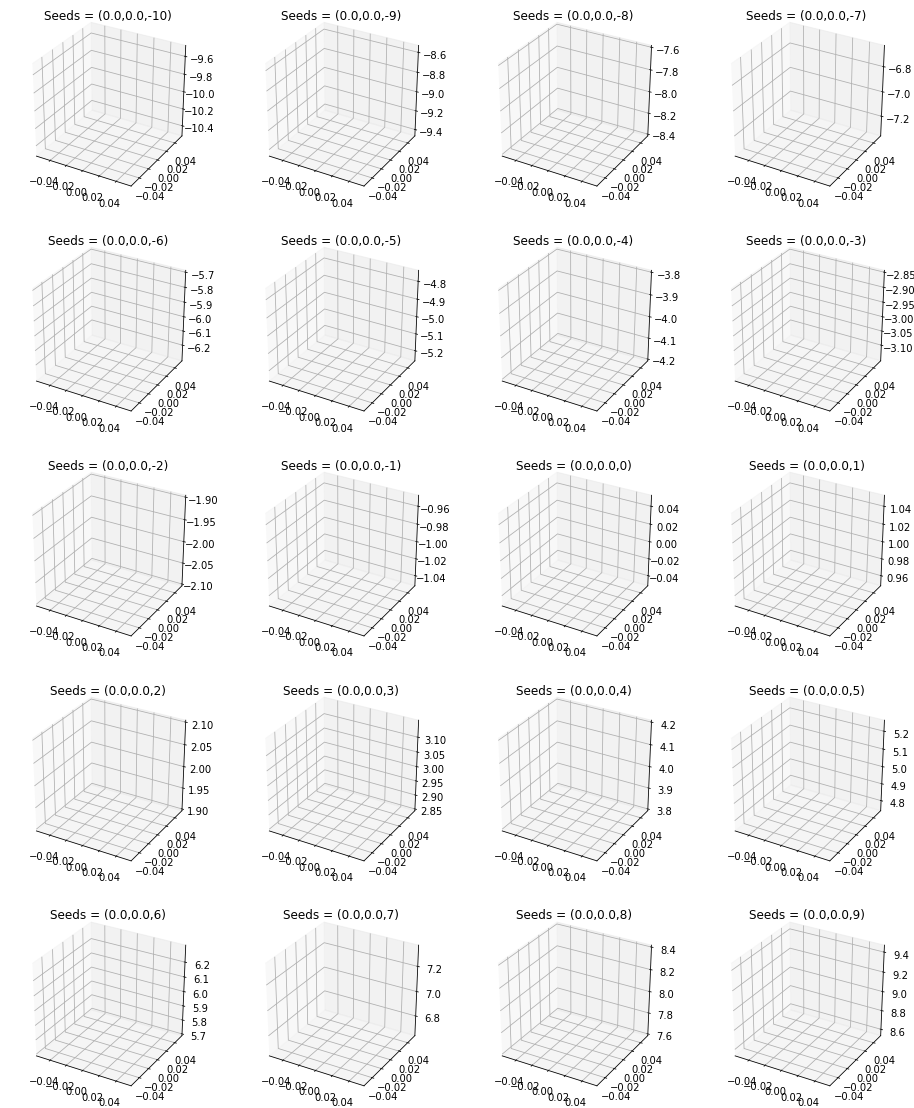

In [92]:
#Compruebo lo enunciado antes

def calculate_new_state(x,y,z):
    return x/2 + y, y - x/2, z - x - y

x_seeds = [0.0]
y_seeds = [0.0]
z_seeds = range(-10, 10)

fig, axs = plt.subplots(5, 4, figsize=(16, 20), subplot_kw={'projection': '3d'})
fig.subplots_adjust(hspace = .2, wspace=.2)
axs = axs.ravel()

i = 0
for x_seed in x_seeds:
    for y_seed in y_seeds:
        for z_seed in z_seeds:
            x =  x_seed
            xs = [x]
            y = y_seed
            ys = [y]
            z = z_seed
            zs = [z]
            for j in range(100):
                x, y, z = calculate_new_state(x,y,z)
                xs.append(x)
                ys.append(y)
                zs.append(z)
                
            axs[i].plot(xs,ys,zs)
            axs[i].set_title(
                "Seeds = ({0},{1},{2})".format(x_seed, y_seed, z_seed))
            i += 1

plt.show()

# Ejercicio 4

<img src="clientes.png" alt="Drawing" style="width: 600px;"/>



In [81]:
import random
import simpy


def source(env, cajero):
    while True:
        global max_number_of_clients_in_the_line
        global current_number_of_clients_in_the_line
        if env.now < 7200:
            interval = 240
        elif env.now < 18000:
            interval = 120
        else:
            interval = 360
        c = customer(env, cajero)
        env.process(c)
        next_arrive = random.expovariate(1.0 / interval)
        yield env.timeout(next_arrive)
        current_number_of_clients_in_the_line += 1
        if current_number_of_clients_in_the_line > max_number_of_clients_in_the_line:
            max_number_of_clients_in_the_line = current_number_of_clients_in_the_line


def customer(env, cajero):
    arrive = env.now
    # print('Client enters')

    with cajero.request() as req:
        yield req
        global max_wait
        global current_number_of_clients_in_the_line
        wait = env.now - arrive # Tiempo de espera en la cola
        if wait > max_wait:
            max_wait = wait
        
        r = random.uniform(0.0,1.0)
        if r < 0.1: 
            time =  random.uniform(60, 420)
        elif r < 0.8:
            time = random.uniform(60,180)
        else:
            time = random.uniform(60,300)
        
        yield env.timeout(time)

        current_number_of_clients_in_the_line -= 1


# Setup and start the simulation
env = simpy.Environment()

max_wait = 0
max_number_of_clients_in_the_line = 0
current_number_of_clients_in_the_line = 0
# Start processes and run
cajero = simpy.Resource(env, capacity=1)
env.process(source(env, cajero))
env.run(until=32400) # Segundos desde las 10.00 hasta las 19.00

In [97]:
print("Max waiting time in seconds: {}".format(max_wait))
print("Max number of clients in the line: {}"
      .format(max_number_of_clients_in_the_line))

Max waiting time in seconds: 2554.94169701
Max number of clients in the line: 39


# Ejercicio 5

<img src="requests.png" alt="Drawing" style="width: 600px;"/>


In [83]:
max_wait = 0
max_number_of_request_in_the_line = 0
number_of_requests = 0
wait_sum = 0
current_number_of_request_in_the_line = 0

import random
import simpy

def source(env, servers):
    while True:
        global max_number_of_request_in_the_line
        global current_number_of_request_in_the_line
        c = solicitud(env, servers)
        env.process(c)
        t = random.expovariate(1.0/45.0)
        yield env.timeout(t)
        current_number_of_request_in_the_line += 1
        if current_number_of_request_in_the_line > max_number_of_request_in_the_line:
            max_number_of_request_in_the_line = current_number_of_request_in_the_line

def solicitud(env, servers):
    arrive = env.now
    
    with next(servers).request() as req:
        yield req
        global max_wait
        global current_number_of_request_in_the_line
        global wait_sum
        global number_of_requests
        wait = env.now - arrive
        if wait > max_wait:
            max_wait = wait
        wait_sum += wait  
        number_of_requests += 1
        
            
        r = random.uniform(0.0,1.0)
        if r < 0.7:                         
            time = random.uniform(60, 180)  # A: 120 +/- 60
        elif r < 0.9:                       
            time = random.uniform(120, 360) # B: 240 +/- 120
        else:                            
            time = random.uniform(200, 800) # C: 500 +/- 300

        yield env.timeout(time)
        current_number_of_request_in_the_line -= 1 


In [84]:
def servers_por_menor_solicitud(servers):
    while True:
        yield min(servers, key = lambda server: len(server.queue))

def servers_por_orden(servers):
    i = 0
    while True:
        yield servers[i%len(servers)]
        i+=1

In [85]:
max_wait = 0
max_number_of_request_in_the_line = 0
number_of_requests = 0
wait_sum = 0
current_number_of_request_in_the_line = 0
env = simpy.Environment()
servers = [simpy.Resource(env, capacity=1) for i in range(5)]

# Start processes and run
env.process(source(env, servers_por_menor_solicitud(servers)))
env.run(until=10**6)

print("Max waiting time in seconds: {}"
      .format(max_wait))
print("Average waiting time in seconds: {}"
      .format(float(wait_sum) / number_of_requests))
print("Max number of requests in the line: {}"
      .format(max_number_of_request_in_the_line))

Max waiting time in seconds: 1479.91128058
Average waiting time in seconds: 171.532339689
Max number of requests in the line: 29


In [86]:
max_wait = 0
max_number_of_request_in_the_line = 0
number_of_requests = 0
wait_sum = 0
current_number_of_request_in_the_line = 0
env = simpy.Environment()
servers = [simpy.Resource(env, capacity=1) for i in range(5)]

# Start processes and run
env.process(source(env, servers_por_orden(servers)))
env.run(until=10**6)

print("Max waiting time in seconds: {}"
      .format(max_wait))
print("Average waiting time in seconds: {}"
      .format(float(wait_sum) / number_of_requests))
print("Max number of requests in the line: {}"
      .format(max_number_of_request_in_the_line))

Max waiting time in seconds: 2554.94169701
Average waiting time in seconds: 262.138168565
Max number of requests in the line: 35


Como se puede ver, conviene usar el método de encolar en el servidor que tiene menos pedidos. Esto se concluye a partir de que todas las metricas tomadas, tiempo de espera promedio, tiempo de espera máximo y cantidad máxima de solicitudes en cola, son mayores, es decir peores, para el caso de la distribución Round Robin. Tener en cuenta que esto se concluye no teniendo en cuenta que la distribución por carga no incluye ningun overhead, lo que no es esperable en la práctica, por lo que ante un escenario mas realista donde medir la carga nos lleve, por ejemplo 80 ms este resultado se invertiria.